### **基于ICESat数据的冰川高程变化估算**

In [48]:
import h5py
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyrsimg import readTiff, imgShow, second_to_dyr, geo2imagexy


In [49]:
path_glah14 = 'data/laser/isat_gla_region.h5'
path_rsimg = 'data/rsimg/s2_gla_region_20220707.tif'
path_dem = 'data/srtm/SRTMGL1Ellip_gla_region.tif'
path_gla_vec = 'data/laser/gla_region.gpkg'


In [50]:
!h5ls $path_glah14
# !h5ls $path_glah14/Data_1HZ/Geolocation/i_track
# !h5ls $path_glah14/Data_40HZ/Elevation_Surfaces


att_flg                  Dataset {215}
delta_ellip              Dataset {215}
elev                     Dataset {215}
elev_cor                 Dataset {215}
elev_flg                 Dataset {215}
lat                      Dataset {215}
lon                      Dataset {215}
satu_corr                Dataset {215}
satu_flag                Dataset {215}
time                     Dataset {215}
time_dyr                 Dataset {215}


In [51]:
vars_glah14 = {}
with h5py.File(path_glah14,'r') as setp_glah14:
    vars_glah14['lat'] = setp_glah14['lat'][:]
    vars_glah14['lon'] = setp_glah14['lon'][:]
    vars_glah14['time_dyr'] = setp_glah14['time_dyr'][:]
    vars_glah14['elev_cor'] = setp_glah14['elev'][:]
    # vars_glah14['elev_dem'] = setp_glah14['elev_dem'][:]
    print(vars_glah14['lat'].shape)

## 2. remote sensing image
rsimg = readTiff(path_rsimg)
## 3. dem image
dem = readTiff(path_dem)
## 4. glacier region
gla_vec = gpd.read_file(path_gla_vec)


(215,)


<Axes: >

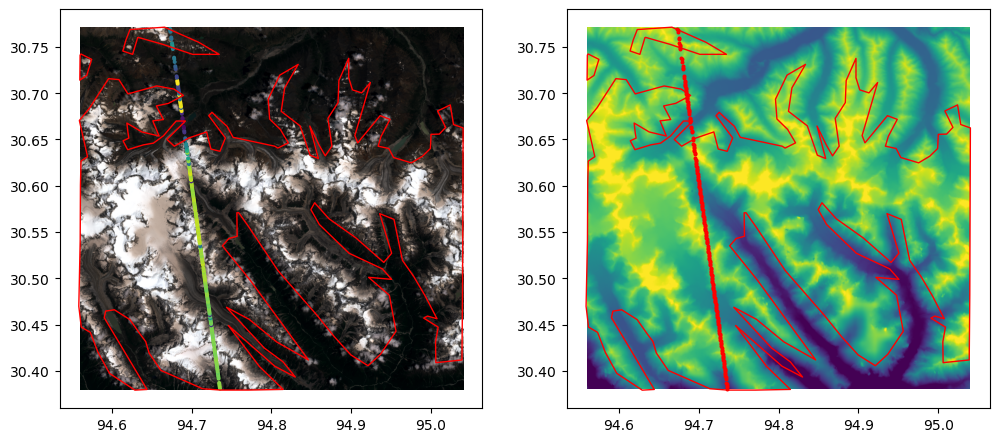

In [52]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
imgShow(rsimg.array, extent=rsimg.geoextent, per_band_clip=10, ax=ax[0])
ax[0].scatter(x=vars_glah14['lon'], y=vars_glah14['lat'], c=vars_glah14['elev_cor'], s=3.5)
imgShow(dem.array, extent=dem.geoextent, ax=ax[1])
ax[1].scatter(x=vars_glah14['lon'], y=vars_glah14['lat'], c='red', s=3.5)
gla_vec.plot(ax=ax[0], facecolor="none", edgecolor='red')
gla_vec.plot(ax=ax[1], facecolor="none", edgecolor='red')


In [53]:
## 筛选出冰川点
ids_gla = np.zeros(shape=(vars_glah14['lon'].shape))
for i, lon in enumerate(vars_glah14['lon']):
    point = Point(lon, vars_glah14['lat'][i])
    if gla_vec.geometry[0].contains(point):
        ids_gla[i]=1
ids_gla


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [54]:
row, col = geo2imagexy(x=vars_glah14['lon'], \
                         y=vars_glah14['lat'], \
                         gdal_trans=dem.geotrans, \
                         rsimg_array = dem.array,\
                         integer=True)
dem_isat_fp = dem.array[row, col]
dem_isat_fp[90:100]


array([5331.00097656, 5373.00390625, 5402.00683594, 5412.00976562,
       5251.01269531, 5138.015625  , 5125.02148438, 5128.02392578,
       5180.02685547, 5234.02978516])

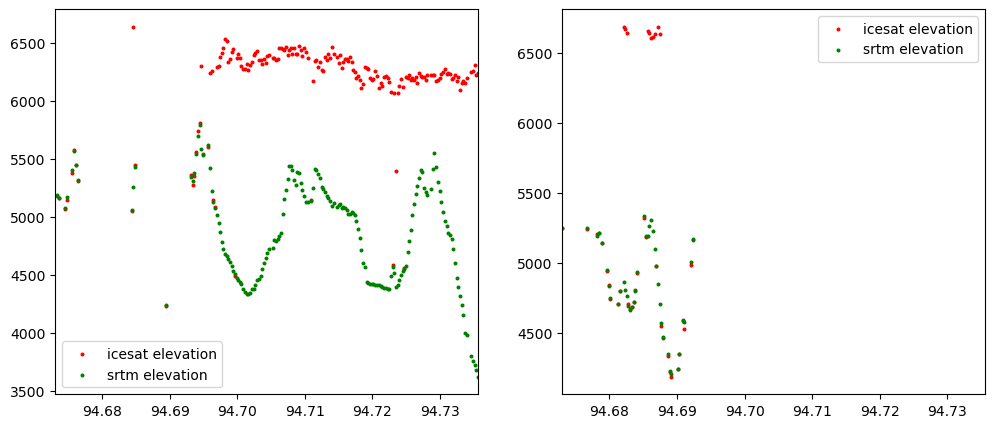

In [55]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].scatter(x=vars_glah14['lon'][ids_gla==1], y=vars_glah14['elev_cor'][ids_gla==1], c='red', s=3.5, label='icesat elevation')  ## icesat data
ax[0].scatter(x=vars_glah14['lon'][ids_gla==1], y=dem_isat_fp[ids_gla==1], c='green', s=3.5, label='srtm elevation')  ## srtm data
ax[0].set_xlim(min(vars_glah14['lon']), max(vars_glah14['lon']))
ax[0].legend()
ax[1].scatter(x=vars_glah14['lon'][ids_gla==0], y=vars_glah14['elev_cor'][ids_gla==0], c='red', s=3.5, label='icesat elevation')  ## icesat data
ax[1].scatter(x=vars_glah14['lon'][ids_gla==0], y=dem_isat_fp[ids_gla==0], c='green', s=3.5, label='srtm elevation')  ## srtm data
ax[1].set_xlim(min(vars_glah14['lon']), max(vars_glah14['lon']))
ax[1].legend()


In [ ]:
## 冰川区域icesat高程与dem高程差异计算
dif_ele = vars_glah14['elev_cor'] - dem_isat_fp
## 冰川区域
ids_gla_thre = np.where((ids_gla==1) & (abs(dif_ele)<150)) ## glacier region and elevation change < 150
dif_ele_gla = dif_ele[ids_gla_thre]
print(dif_ele_gla.mean())
## 非冰川区域
ids_stable_thre = np.where((ids_gla==0) & (abs(dif_ele)<50)) ## non-glacier region and elevation change < 50
dif_ele_stable = dif_ele[ids_stable_thre]
print(dif_ele_stable.mean())



-0.9162506249998842
-4.005320182291538


In [57]:
dif_val_gla_cor = dif_ele_gla.mean()-dif_ele_stable.mean()
dif_val_gla_cor


np.float64(3.0890695572916536)

In [ ]:
## 冰川消融速度计算
gla_ele_change_rate = dif_val_gla_cor/(vars_glah14['time_dyr'][0]-2000)   ## srtm time is 2000/2/11
print(vars_glah14['time_dyr'][0])
print(gla_ele_change_rate)


2004.8348295626067
0.6389200523598525


In [59]:
### 标准差估算
sigma = np.std(dif_ele_stable)
print(sigma)


11.7079253222499
